In [11]:
'''
IST-718: Lab 3 Homework
-----------------------
Implement at least two approaches for classifying the digits
'''

# Part-1: Build a CNN using PyTorch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn  # Has all the essential pkgs for nueral-nets
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Check if we got the GPU
print(device)

cuda:0


In [12]:
# Get the Fashion MNIST data from torchvision
train_set = torchvision.datasets.MNIST("./data_mnist", download=True, transform=
                                       transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.MNIST("./data_mnist", download=True, train=False, transform=
                                      transforms.Compose([transforms.ToTensor()])) 

# Load the Fashion MNIST data
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


Extracting ./data_mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data_mnist/MNIST/raw



Extracting ./data_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data_mnist/MNIST/raw



Extracting ./data_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data_mnist/MNIST/raw



Extracting ./data_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data_mnist/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
# Validate size of data (we expect to have 60k MNIST images in the train-set)
print('Train images - %d' %len(train_set))

# Validate size of data (we expect to have 10k MNIST images in the test-set)
print('Test set - %d' %len(test_set))

sample = next(iter(train_loader))
sample[0].size()

Train images - 60000
Test set - 10000


torch.Size([100, 1, 28, 28])

5


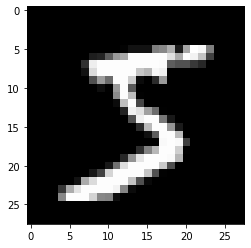

In [16]:
# Explore the data
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")

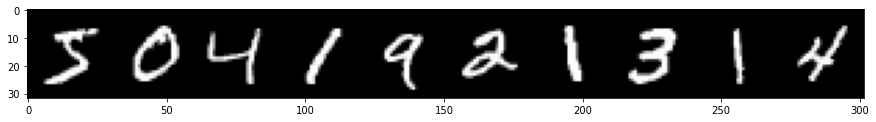

In [17]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch

grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))

In [23]:
'''
Setting up CNN
--------------
(1) Two Sequential layers. Each consists:
  - Convolution stage:
     - with kernel size of 3 * 3, padding = 1  and 0 respectively 
     - stride 1
  - Normalization stage
  - Detector stage
     - Activation function: ReLU (Rectified linear activation function)
  - Pooling stage (Max pooling)
     - with kernel size of 2 * 2
     - stride 2

(2) Fully connected or dense layers
  - 3x Fully connected layers with different in/out features

(3) Dropout layer that has class probability p = 0.25

All the functionality is given in forward method that defines the forward 
pass of CNN

NOTE: We don't use a softmax/sigmoid activation on the output layer and instead 
allow Pytorch to apply the built-in Cross-entropy function
''' 

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        # First convolutional layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Second convoultional layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Define the fully-connected/dense layers
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        
        # Adjust the weights and the bias via a Dropout layer
        self.drop = nn.Dropout2d(0.25)
 
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        
        # Define a final dense layer with outputs equal to number of labels
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [22]:
model = CNN()
model.to(device)

error = nn.CrossEntropyLoss()

# Adjust the amount of weights that are updated by error gradient
learning_rate = 0.001

# torch.optim offers various optimizers like SGM, Adam etc.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check the final model
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [24]:
import timeit

def run_cnn_model():
    # Training the network and testing it on the test dataset
    num_epochs = 5
    count = 0

    # Lists for visualization of loss and accuracy 
    loss_list = []
    iteration_list = []
    accuracy_list = []

    # Lists for knowing classwise accuracy
    predictions_list = []
    labels_list = []
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)
    
            train = Variable(images.view(100, 1, 28, 28))
            labels = Variable(labels)
        
            # Forward pass 
            outputs = model(train)
            loss = error(outputs, labels)
        
            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()
        
            # Propagating the error backward
            loss.backward()
        
            # Optimizing the parameters
            optimizer.step()
    
            count += 1
    
        # Testing the model
            if not (count % 50):   
                total = 0
                correct = 0

                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    labels_list.append(labels)
            
                    # Wrap the tensor with Variable() to easily compute gradient
                    test = Variable(images.view(100, 1, 28, 28))
            
                    outputs = model(test)
            
                    predictions = torch.max(outputs, 1)[1].to(device)
                    predictions_list.append(predictions)
                    correct += (predictions == labels).sum()
                    total += len(labels)
            
                accuracy = correct * 100 / total
                loss_list.append(loss.data)
                iteration_list.append(count)
                accuracy_list.append(accuracy)
        
            if not (count % 500):
                print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))
        
    return(iteration_list, loss_list, accuracy_list)

# Setup constructs for timeit module
SETUP_CODE = '''
from __main__ import run_cnn_model
'''
TEST_CODE = '''
iteration_list, loss_list, accuracy_list = run_cnn_model()
'''

#  Run the model using timeit()
timeit.timeit(setup=SETUP_CODE, stmt=TEST_CODE, number=1)

Iteration: 500, Loss: 0.20407743752002716, Accuracy: 94.55999755859375%
Iteration: 1000, Loss: 0.1611713171005249, Accuracy: 97.04999542236328%
Iteration: 1500, Loss: 0.15159371495246887, Accuracy: 97.72000122070312%
Iteration: 2000, Loss: 0.01575990952551365, Accuracy: 98.22000122070312%
Iteration: 2500, Loss: 0.0031221627723425627, Accuracy: 98.54999542236328%
Iteration: 3000, Loss: 0.13699766993522644, Accuracy: 98.93999481201172%


66.11543390500015

In [25]:
# Calculate the accuracy per class
class_correct = [0. for _ in range(10)]
total_correct = [0. for _ in range(10)]

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(i, class_correct[i] * 100 / total_correct[i]))

Accuracy of 0: 99.49%
Accuracy of 1: 99.74%
Accuracy of 2: 99.13%
Accuracy of 3: 99.11%
Accuracy of 4: 98.37%
Accuracy of 5: 99.10%
Accuracy of 6: 98.64%
Accuracy of 7: 98.54%
Accuracy of 8: 99.18%
Accuracy of 9: 98.71%


In [66]:
# Part-2: Build a Multi-layer Perceptron model using Keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras import backend as K
K.image_data_format()

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Rows: %d, columns: %d' % (x_train.shape[0], x_train.shape[1]))
print('Rows: %d, columns: %d' % (x_test.shape[0], x_test.shape[1]))

Rows: 60000, columns: 28
Rows: 10000, columns: 28


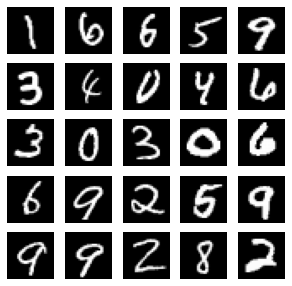

In [67]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')

In [68]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [69]:
# resize and normalize
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255

print(x_train.shape, y_train.shape)

(60000, 784) (60000, 10)


In [70]:
NUM_CATEGORIES = 10

# Build the model
mlp_model = Sequential()

mlp_model.add(Dense(512, input_dim = input_size))
mlp_model.add(Activation('relu'))

mlp_model.add(Dense(512))
mlp_model.add(Activation('relu'))

mlp_model.add(Dense(512))
mlp_model.add(Activation('relu'))

mlp_model.add(Dense(NUM_CATEGORIES))
mlp_model.add(Activation('softmax'))

# compile it - categorical crossentropy is for multiple choice classification
mlp_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [79]:
# Train and validate the model
def run_mlp_model():
  mlp_model.fit(x_train, y_train,
            epochs = 5,
            batch_size = 100,
            validation_data = (x_test, y_test))
  
  
# Setup constructs for timeit module
SETUP_CODE = '''
from __main__ import run_mlp_model
'''
TEST_CODE = '''
mlp_model = run_mlp_model()
'''

#  Run the model using timeit()
timeit.timeit(setup=SETUP_CODE, stmt=TEST_CODE, number=1)

Epoch 1/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0168 - accuracy: 0.9980 - val_loss: 0.2919 - val_accuracy: 0.9828
Epoch 2/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0160 - accuracy: 0.9977 - val_loss: 0.3380 - val_accuracy: 0.9834
Epoch 3/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0141 - accuracy: 0.9983 - val_loss: 0.4064 - val_accuracy: 0.9818
Epoch 4/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0202 - accuracy: 0.9978 - val_loss: 0.3362 - val_accuracy: 0.9823
Epoch 5/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0145 - accuracy: 0.9980 - val_loss: 0.4664 - val_accuracy: 0.9796
Epoch 1/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0158 - accuracy: 0.9980 - val_loss: 0.4610 - val_accuracy: 0.9833
Epoch 2/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0192 - accuracy: 0.9981 - val_loss: 0.3343 - val_accuracy: 0.9847
Epoch 3/5
600

Epoch 1/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0133 - accuracy: 0.9987 - val_loss: 0.4651 - val_accuracy: 0.9835
Epoch 2/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0164 - accuracy: 0.9982 - val_loss: 0.4629 - val_accuracy: 0.9838
Epoch 3/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0114 - accuracy: 0.9987 - val_loss: 0.5062 - val_accuracy: 0.9805
Epoch 4/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0116 - accuracy: 0.9988 - val_loss: 0.5054 - val_accuracy: 0.9821
Epoch 5/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0082 - accuracy: 0.9990 - val_loss: 0.5360 - val_accuracy: 0.9848


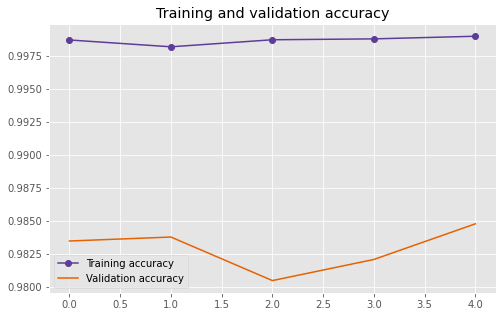

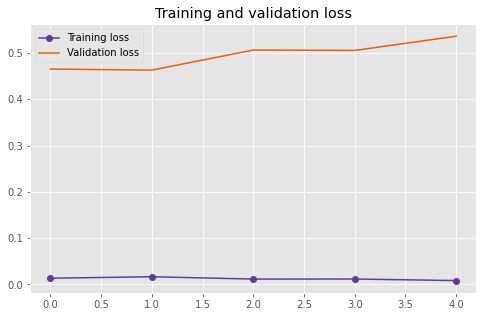

In [81]:
# Run the model/validation again to plot the train vs validation accuracy
history = mlp_model.fit(x_train, y_train,
            epochs = 5,
            batch_size = 100,
            validation_data = (x_test, y_test))

def plot_train_curve(history):
    colors = ['#e66101','#fdb863','#b2abd2','#5e3c99']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accuracy))
    with plt.style.context("ggplot"):
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, accuracy, marker='o', c=colors[3], label='Training accuracy')
        plt.plot(epochs, val_accuracy, c=colors[0], label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure(figsize=(8, 8/1.618))
        plt.plot(epochs, loss, marker='o', c=colors[3], label='Training loss')
        plt.plot(epochs, val_loss, c=colors[0], label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()
    
plot_train_curve(history)

In [83]:
# Adding a couple of drop-layers to see any improvement
'''
A neural network has the property to memorize the characteristics of training data. This is called overfitting.
In such a case, the network fails to generalize when subject to the test data.
To avoid this tendency, the model uses a regularizing layer or function. A commonly used regularizing layer is referred to as a Dropout layer.
Given a dropout rate (dropout=0.45), the Dropout layer randomly removes the fraction of units from participating in the next layer. 
For example, if the first layer has 256 units, after dropout=0.45 is applied, only (1 - 0.45) * 256 units = 140 units from layer 1 participate in layer 2.
The Dropout layer makes neural networks robust to unforeseen input data because the network is trained to predict correctly, even if some units are missing.
'''

# Build the model
mlp_model = Sequential()

mlp_model.add(Dense(512, input_dim = input_size))
mlp_model.add(Activation('relu'))

# Adding a new drop-out layer
mlp_model.add(Dropout(0.15))

mlp_model.add(Dense(512))
mlp_model.add(Activation('relu'))

# Adding a new drop-out layer
mlp_model.add(Dropout(0.15))

mlp_model.add(Dense(512))
mlp_model.add(Activation('relu'))

mlp_model.add(Dense(NUM_CATEGORIES))
mlp_model.add(Activation('softmax'))

# compile it - categorical crossentropy is for multiple choice classification
mlp_model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

Epoch 1/5
600/600 [==============================] - 3s 3ms/step - loss: 0.4284 - accuracy: 0.8628 - val_loss: 0.1554 - val_accuracy: 0.9556
Epoch 2/5
600/600 [==============================] - 2s 3ms/step - loss: 0.1092 - accuracy: 0.9681 - val_loss: 0.0991 - val_accuracy: 0.9721
Epoch 3/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0771 - accuracy: 0.9769 - val_loss: 0.0774 - val_accuracy: 0.9789
Epoch 4/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0701 - accuracy: 0.9809 - val_loss: 0.0847 - val_accuracy: 0.9779
Epoch 5/5
600/600 [==============================] - 2s 3ms/step - loss: 0.0619 - accuracy: 0.9831 - val_loss: 0.0890 - val_accuracy: 0.9774


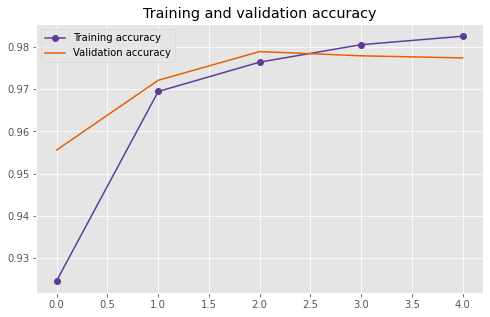

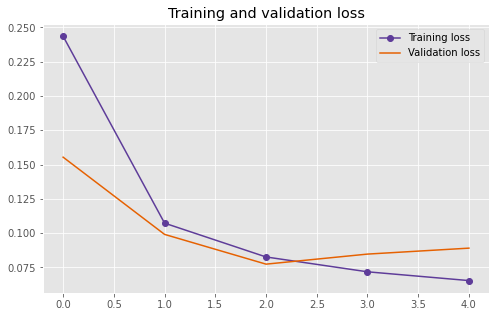

In [84]:
# Run the model and validation
history = mlp_model.fit(x_train, y_train,
            epochs = 5,
            batch_size = 100,
            validation_data = (x_test, y_test))

# Finally, plot the train vs validation accuracy
plot_train_curve(history)